Summpip Paper Implementation

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!export LC_ALL=en_US.UTF-8

In [31]:
#make all necessary imports
import numpy as np
import nltk
import nltk.data
import os
import spacy
import tensorflow_hub as hub
import copy
import gensim.downloader as api
!pip install rouge
!pip install ordered-set
!pip install scikit-fuzzy
import spacy
import scipy
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from skfuzzy.cluster import cmeans
from rouge import Rouge
from sklearn.cluster import SpectralClustering
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import wordnet as wn
from ordered_set import OrderedSet
sentence_detector = nltk.data.load('tokenizers/punkt/english.pickle')
use_tensorflow_embedding = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
glove_word_vectors = api.load("glove-wiki-gigaword-100")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 44.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894086 sha256=bea13c6391b93182354048316a45ae8d6172510fdb29b005b312bf3a86af4ef9
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Extracting Sentences out of Data. (Preprocessing Step)

In [25]:
with open('/content/drive/MyDrive/SMAI/Project/DocsData.txt', 'r') as file:
    lines = file.readlines()

doc_separator_tag="story_separator_special_tag"
cnt = 0
line_sent_list = []
for line in lines:
    line = line.replace(doc_separator_tag, "")
    sent_list = sentence_detector.tokenize(line.strip())
    line_sent_list.append(sent_list)
    cnt += 1
    if cnt <= 5:
        print(sent_list)

print(len(line_sent_list))
docs = line_sent_list[:1]
print('Docs data for analysis')
print(docs)

["GOP Eyes Gains As Voters In 11 States Pick Governors Enlarge this image toggle caption Jim Cole / AP Jim Cole / AP Voters in 11 states will pick their governors tonight , and Republicans appear on track to increase their numbers by at least one , with the potential to extend their hold to more than two - thirds of the nation 's top state offices .", 'Eight of the gubernatorial seats up for grabs are now held by Democrats ; three are in Republican hands .', "Republicans currently hold 29 governorships , Democrats have 20 , and Rhode Island 's Gov.", 'Lincoln Chafee is an Independent .', "Polls and race analysts suggest that only three of tonight 's contests are considered competitive , all in states where incumbent Democratic governors are n't running again : Montana , New Hampshire and Washington .", 'While those state races remain too close to call , Republicans are expected to wrest the North Carolina governorship from Democratic control , and to easily win GOP - held seats in Utah

Graph Construction Step (Node will be a sentence)

In [26]:
#using spacynlp for POS(part of speech) tagging
spacynlp=spacy.load("en_core_web_sm")
verbs_to_escape = ["be", "is","am","are","was", "were", "being","been","do","did",
               "done","have","had","get","got","gotten"]

discourseMarkers=["for","so","because","since","therefore","consequently","additionally","furthermore","moreover",
         "but","however","although","despite","similarly","otherwise","whereas","while","unlike","thus",
        "instead","nevertheless","afterward","finally","subsequently","conversely","later","next","then",
         "likewise","compared","besides","further","as","also","equally","hence","accordingly","stil",
        "simultaneously"]

def convert_verb_to_nouns(sentence):
    tokens = spacynlp(sentence)
    nouns_arr = []
    for token in tokens:
        if token.pos_ == 'VERB' and token.text not in verbs_to_escape:
            tokenNouns = getNouns(token.text)
            # print('Here ', token.text, '-->> ', tokenNouns)
            nouns_arr.extend(tokenNouns)
            # print(nouns_arr)
    return nouns_arr

#Using getNouns to get lemmas(base word) of verbs
def getNouns(verb):
    baseform = wn.morphy(verb, wn.VERB)
    if baseform:
        lemmas = wn.lemmas(baseform, pos='v')
        noun_forms = []
        for lemma in lemmas:
            nouns = [form.name() for form in lemma.derivationally_related_forms()]
            noun_forms.extend(nouns)
        noun_forms = OrderedSet(noun_forms)
        return noun_forms
    else:
        return []
    
#find similar nouns based on cosine similarity from glove vectors dataset
def find_similar_nouns(nouns_list, word_vecs, thres=0.75):
    similar_nouns = []
    nouns = list(set(nouns_list))
    for noun in nouns:
        try:
            sim_word_list = word_vecs.most_similar(positive=[noun])
            sim_word_list = [tup[0] for tup in sim_word_list if tup[1]>thres]
            similar_nouns.extend(sim_word_list)
        except KeyError:
            pass
        similar_nouns.extend(nouns_list)
        return list(set(similar_nouns))
    
#Check for deverbal nouns in successive sentence
def check_deverbal_noun(similar_nouns, sent2):
    edge = False
    sent2words = spacynlp(sent2)
    if len(sent2words)>0:
        for token in sent2words:
            if token.pos_ == 'NOUN':
                if token.text in similar_nouns:
                    edge = True
                    break
    return edge

def check_discourse_markers(sent1, sent2):
    edge = False
    sent2words = spacynlp(sent2)
    if len(sent2words)>0:
        firstWord = sent2words[0].text
        if firstWord.lower() in discourseMarkers:
            edge = True
    return edge

def check_entity_continuation(sent1, sent2):
    edge = False
    words1 = spacynlp(sent1)
    words2 = spacynlp(sent2)
    if len(words1) > 0 and len(words2) > 0:
        entity1 = [(ent.text, ent.label_) for ent in words1.ents]
        entity2 = [(ent.text, ent.label_) for ent in words2.ents]
        for (text, label) in entity1:
            if (text, label) in entity2:
                edge=True
                break
    return edge
    

def checkCosineSimilarity(sent1Vec, sent2Vec):
    edge = False
    similarity = 1 - scipy.spatial.distance.cosine(sent1Vec,sent2Vec)
    if similarity >= 0.55:
        edge = True
    return edge
    

Number of nodes:  19
["GOP Eyes Gains As Voters In 11 States Pick Governors Enlarge this image toggle caption Jim Cole / AP Jim Cole / AP Voters in 11 states will pick their governors tonight , and Republicans appear on track to increase their numbers by at least one , with the potential to extend their hold to more than two - thirds of the nation 's top state offices .", 'Eight of the gubernatorial seats up for grabs are now held by Democrats ; three are in Republican hands .', "Republicans currently hold 29 governorships , Democrats have 20 , and Rhode Island 's Gov.", 'Lincoln Chafee is an Independent .', "Polls and race analysts suggest that only three of tonight 's contests are considered competitive , all in states where incumbent Democratic governors are n't running again : Montana , New Hampshire and Washington .", 'While those state races remain too close to call , Republicans are expected to wrest the North Carolina governorship from Democratic control , and to easily win GOP

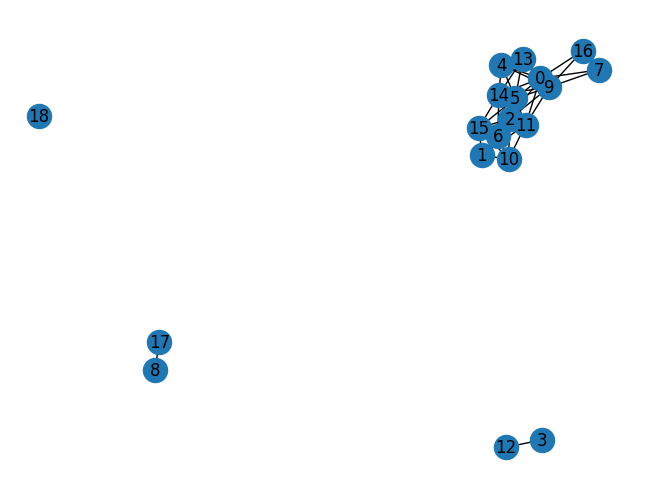

{0: 0.5, 1: 0.2777777777777778, 2: 0.5, 3: 0.05555555555555555, 4: 0.2777777777777778, 5: 0.5, 6: 0.38888888888888884, 7: 0.16666666666666666, 8: 0.05555555555555555, 9: 0.5, 10: 0.2777777777777778, 11: 0.5, 12: 0.05555555555555555, 13: 0.2777777777777778, 14: 0.5, 15: 0.38888888888888884, 16: 0.16666666666666666, 17: 0.05555555555555555, 18: 0.0}


In [27]:
embed_size = 512 #for tensorflow embedding
adj_matrix = None
sentence_embeddings_matrix = None
# use_tensorflow_embedding = hub.load('./universal-sentence-encoder_4')

#declares adjacency matrix and gives number of nodes and sentence embeddings(vector of size 512, per sentence)
def build_sentence_graph(document):
    num_nodes = len(document)
    # print(document)
    print('Number of nodes: ', num_nodes)
    sentence_embeddings_matrix = np.zeros([num_nodes, embed_size])
    adj_matrix = np.zeros([num_nodes, num_nodes])
    cnt = 0
    for sentence in document:
        sentence_embeddings_matrix[cnt] = use_tensorflow_embedding([sentence]).numpy()[0]
        cnt += 1
    return  num_nodes, adj_matrix,sentence_embeddings_matrix




#Fills Adjacency Matrix
def connect_sentence_nodes(document, num_nodes, adj_matrix, sentence_embeddings_matrix):
    for i in range(num_nodes):
        connect = False
        sentence1 = document[i]
        for j in range(i+1, num_nodes):
            sentence2 = document[j]
            if j-i == 1:
                nouns_list = convert_verb_to_nouns(sentence1)
                similar_nouns_list = find_similar_nouns(nouns_list, glove_word_vectors, 0.5)
                # print('Similar Nouns list: ', similar_nouns_list, ' for sentence ', sentence1)
                if similar_nouns_list is not None:
                    connect = check_deverbal_noun(similar_nouns_list, sentence2)
                if connect == False:
                    connect = check_discourse_markers(sentence1, sentence2)
            else:
                connect = check_entity_continuation(sentence1, sentence2)
            if connect == False:
                connect = checkCosineSimilarity(sentence_embeddings_matrix[i,], sentence_embeddings_matrix[j,])
            if connect == True:
                adj_matrix[i,j] = 1
                adj_matrix[j,i] = 1
    return adj_matrix

def visualize(adj_mat):
    G = nx.from_numpy_array(adj_mat)
    nx.draw(G, with_labels=True)
    plt.show()
    degree_centrality = nx.degree_centrality(G)
    print(degree_centrality)

for doc in docs:
    num_nodes, adj_matrix, sentence_embeddings_matrix = build_sentence_graph(doc)
    adj_matrix = connect_sentence_nodes(doc, num_nodes, adj_matrix, sentence_embeddings_matrix)
    print(doc)
    print(adj_matrix)
    visualize(adj_matrix)

Perform Spectral Clustering on the Constructed Graph

["GOP Eyes Gains As Voters In 11 States Pick Governors Enlarge this image toggle caption Jim Cole / AP Jim Cole / AP Voters in 11 states will pick their governors tonight , and Republicans appear on track to increase their numbers by at least one , with the potential to extend their hold to more than two - thirds of the nation 's top state offices .", 'Eight of the gubernatorial seats up for grabs are now held by Democrats ; three are in Republican hands .', "Republicans currently hold 29 governorships , Democrats have 20 , and Rhode Island 's Gov.", 'Lincoln Chafee is an Independent .', "Polls and race analysts suggest that only three of tonight 's contests are considered competitive , all in states where incumbent Democratic governors are n't running again : Montana , New Hampshire and Washington .", 'While those state races remain too close to call , Republicans are expected to wrest the North Carolina governorship from Democratic control , and to easily win GOP - held seats in Utah

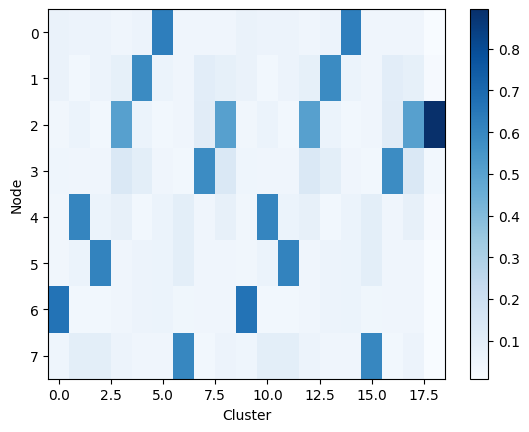

In [32]:
cluster_dict_final = {}
def spectralClustering(adj_mat, doc):
    clustering = SpectralClustering(n_clusters = 8, random_state = 88).fit(adj_mat)
    clusterIDs = clustering.labels_
    print(clusterIDs)
    num_clusters = max(clusterIDs)+1
    cluster_dict={new_list:[] for new_list in range(num_clusters)}
    for idx, id in enumerate(clusterIDs):
        cluster_dict[id].append(doc[idx])
    return cluster_dict

def fuzzyCMeansClustering(adj_mat, doc):
    # Define FCM parameters
    fuzziness = 2.0
    max_iter = 3000
    error = 0.005
    n_clusters = 8
    # Perform FCM clustering on the adjacency matrix
    centers, membership, k1, d, jm, p, fpc = cmeans(adj_mat, n_clusters, fuzziness, error,max_iter)
    # Get cluster labels for each vertex
    labels = np.argmax(membership, axis=0)

    # Print the cluster labels
    print(labels)

    fig, ax = plt.subplots()
    im = ax.imshow(membership, cmap='Blues', aspect='auto')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Node')
    plt.colorbar(im)
    plt.show()
    num_clusters = max(labels)+1
    cluster_dict={new_list:[] for new_list in range(num_clusters)}
    for idx, id in enumerate(labels):
        cluster_dict[id].append(doc[idx])
    return cluster_dict



for doc in docs:
    print(doc)
    # cluster_dict_final = spectralClustering(adj_matrix, doc)
    cluster_dict_final = fuzzyCMeansClustering(adj_matrix, doc)

Generate Summary from the Clusters Generated

In [33]:
import sys
sys.path.append('/content/drive/MyDrive/SMAI/Project')

In [34]:
import takahe

def tag_pos(sentence):
    words = spacynlp(sentence)
    textlist = []
    for word in words:
        token = word.text
        pos = word.tag_
        textlist.append(token+'/'+pos)
    return ' '.join(textlist)
    
def convert_to_tagged_sentences(sentences):
    tagged_list = []
    if len(sentences):
        for sentence in sentences:
            sentence.replace('/','')
            sent_tagged = tag_pos(sentence)
            tagged_list.append(sent_tagged)
    else:
        tagged_list.append(tag_pos("."))
    return tagged_list


def getCompressedSentence(sentences):
    compresser = takahe.word_graph(sentence_list = sentences, nb_words = 5, lang = 'en', punct_tag = "." )
    candidates = compresser.get_compression(3)
    reranker = takahe.keyphrase_reranker(sentences, candidates, lang = 'en')

    reranked_candidates = reranker.rerank_nbest_compressions()
    # print(reranked_candidates)
    if len(reranked_candidates)>0:
        score, path = reranked_candidates[0]
        result = ' '.join([u[0] for u in path])
    else:
        result=' '
    return result

def perform_cluster_compression(cluster_dict):
    generated_summary = []
    for clusterID, sentences in cluster_dict.items():
        tagged_sentences = convert_to_tagged_sentences(sentences)
        print(getCompressedSentence(tagged_sentences))

perform_cluster_compression(cluster_dict_final)

while those state races remain too close to call , republicans are expected to wrest the north carolina governorship from democratic control , and to easily win gop - held seats in utah , north dakota and indiana .
polls and race analysts suggest that only three of tonight 's contests are considered competitive , all in states where incumbent democratic governors are n't running again : montana , new hampshire and washington .
lincoln chafee is an independent .
holding sway on health care while the occupant of the governor 's office is historically far less important than the party that controls the state legislature , top state officials in coming years are expected to wield significant influence in at least one major area .
eight of the gubernatorial seats up for grabs today are now held by democrats ; three are in republican hands .
republicans currently hold 29 governorships , democrats have 20 , and rhode island 's gov.
gop eyes gains as voters in 11 states pick governors jim cole

In [41]:
target_text = "it ' s a race for the governor ' s mansion in 11 states today , and the gop could end the night at the helm of more than two-thirds of the 50 states . the gop currently controls 29 of the country ' s top state offices ; it ' s expected to keep the three republican ones that are up for grabs ( utah , north dakota , and indiana ) , and wrest north carolina from the dems . that brings its toll to 30 , with the potential to take three more , reports npr . races in montana , new hampshire , and washington are still too close to call , and in all three , democrat incumbents aren ' t seeking reelection . the results could have a big impact on health care , since a supreme court ruling grants states the ability to opt out of obamacare ' s medicaid expansion .  a romney victory would dramatically empower republican governors , said one analyst . click for npr ' s state-by-state breakdown of what could happen ."
predicted_text = "while those state races remain too close to call , republicans are expected to wrest the north carolina governorship from democratic control , and to easily win gop - held seats in utah , north dakota and indiana .polls and race analysts suggest that only three of tonight 's contests are considered competitive , all in states where incumbent democratic governors are n't running again : montana , new hampshire and washington .lincoln chafee is an independent .holding sway on health care while the occupant of the governor 's office is historically far less important than the party that controls the state legislature , top state officials in coming years are expected to wield significant influence in at least one major area .eight of the gubernatorial seats up for grabs today are now held by democrats ; three are in republican hands .republicans currently hold 29 governorships , democrats have 20 , and rhode island 's gov.gop eyes gains as voters in 11 states pick governors jim cole / ap jim cole / ap voters in 11 states will pick their governors tonight , and republicans appear on track to increase their numbers by at least one , with the potential to extend their hold to more than two - thirds of the nation 's top state offices .democrats are likely hold on to their seats in west virginia and missouri ; and expected to notch safe wins in races for seats they hold in vermont and delaware ."
# predicted_text = "while those state races remain too close to call , republicans are expected to wrest the north carolina governorship from democratic control , and to easily win gop - held seats in utah , north dakota and indiana .polls and race analysts suggest that only three of tonight 's contests are considered competitive , all in states where incumbent democratic governors are n't running again : montana , new hampshire and washington .lincoln chafee is an independent .holding sway on health care while the occupant of the governor 's office is historically far less important than the party that controls the state legislature , top state officials in coming years are expected to wield significant influence in at least one major area ."
rouge = Rouge()

# Calculate Rouge-1 score
rouge_1 = rouge.get_scores(target_text, predicted_text, avg=True)['rouge-1']['f']

# Calculate Rouge-2 score
rouge_2 = rouge.get_scores(target_text, predicted_text, avg=True)['rouge-2']['f']

# Calculate Rouge-L score
rouge_l = rouge.get_scores(target_text, predicted_text, avg=True)['rouge-l']['f']

# Results
print("Rouge-1 score: {:.2f}".format(rouge_1))
print("Rouge-2 score: {:.2f}".format(rouge_2))
print("Rouge-L score: {:.2f}".format(rouge_l))

Rouge-1 score: 0.42
Rouge-2 score: 0.15
Rouge-L score: 0.36
